In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2DTranspose, Reshape
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.python.client import device_lib

In [3]:
print(device_lib.list_local_devices())

In [14]:
IMG_SIZE = 512

In [5]:
# Fonction pour charger les images avec PIL
def load_images(chemin_dossier):
    images = []
    max_images = 10000
    image = 1
    for filename in os.listdir(chemin_dossier):
        if image >= max_images:
            break
        chemin_image = os.path.join(chemin_dossier, filename)
        img = Image.open(chemin_image).convert("L")  # Convertit en niveaux de gris
        img = img.resize(
            (IMG_SIZE, IMG_SIZE)
        )  # Redimensionne l'image à la taille attendue
        img = np.array(img)  # Convertit l'image PIL en tableau NumPy
        img = img / 127.5 - 1.0  # Normalise dans la plage [-1, 1]
        if img is not None:
            images.append(img)
        image += 1
    return np.array(images)

In [13]:
# Fonction pour créer le générateur
def build_generator(latent_dim):
    model = Sequential()
    model.add(
        layers.Dense(256 * (IMG_SIZE // 8) * (IMG_SIZE // 8), input_dim=latent_dim)
    )
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((IMG_SIZE // 8, IMG_SIZE // 8, 256)))
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(
        Conv2DTranspose(1, kernel_size=4, strides=2, padding="same", activation="tanh")
    )
    return model


# Fonction pour créer le discriminateur
def build_discriminator():
    img_shape = (IMG_SIZE, IMG_SIZE, 1)
    model = Sequential()
    model.add(
        layers.Conv2D(
            64, kernel_size=4, strides=2, padding="same", input_shape=img_shape
        )
    )
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(256, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))
    return model


# Fonction pour compiler le modèle GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(
        loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0002, beta_1=0.5)
    )
    return model


# Fonction pour générer et afficher une image à partir du générateur dans le notebook
def generate_and_show_image(generator, gan_model, epochs, latent_dim):
    # Générer un vecteur de bruit aléatoire
    noise = np.random.randn(1, latent_dim)

    # Utiliser le générateur pour produire une image
    generated_img = generator.predict(noise)

    # Réajuster la normalisation [0, 1]
    generated_img = 0.5 * generated_img + 0.5

    # Afficher l'image générée
    plt.imshow(generated_img[0, :, :, 0], cmap="gray")
    plt.axis("off")
    plt.title(f"Generated Image - Epoch {epochs}")
    plt.show()


# Fonction pour entraîner la GAN
def train_gan(generator, discriminator, gan, epochs, batch_size, latent_dim, images):
    print("Lancement de l'entraînement...")
    for epoch in range(epochs):
        # Entraînement du discriminateur
        idx = np.random.randint(0, images.shape[0], batch_size)
        real_imgs = images[idx]
        fake_imgs = generator.predict(np.random.randn(batch_size, latent_dim))
        labels_real = np.ones((batch_size, 1))
        labels_fake = np.zeros((batch_size, 1))
        d_loss_real = discriminator.train_on_batch(real_imgs, labels_real)
        d_loss_fake = discriminator.train_on_batch(fake_imgs, labels_fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Entraînement du générateur
        noise = np.random.randn(batch_size, latent_dim)
        labels_gan = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, labels_gan)

        # Affichage de la progression
        print(f"Epoch {epoch}/{epochs} [D loss: {d_loss} | G loss: {g_loss}]")
    print("Entraînement terminé !")


def train_or_load_model(latent_dim, epochs, batch_size):
    gan_name = "goblin.h5"
    # On vérifie que le modèle sauvegardé existe
    if os.path.exists("A:/python/" + gan_name):
        print("Chargement du modèle existant...")
        gan = tf.keras.models.load_model("A:/python/" + gan_name)
        print("Chargement du modèle terminé !")
    else:
        print("Entraînement d'un nouveau modèle...")
        # On crée et compile les modèles
        generator = build_generator(latent_dim)
        discriminator = build_discriminator()

        discriminator.compile(
            loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0002, beta_1=0.5)
        )
        gan = build_gan(generator, discriminator)
        gan.compile(
            loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0002, beta_1=0.5)
        )

        # On charge les images pour l'entraînement
        print("Chargement des images...")
        images = load_images("A:/python/training/images/images/")

        # On entraîne le modèle
        train_gan(generator, discriminator, gan, epochs, batch_size, latent_dim, images)

        # On sauvegarde le modèle après l'entraînement
        gan.save("A:/python/" + gan_name)

    # On récupère le générateur du modèle GAN
    generator = gan.layers[1]

    return gan, generator

In [ ]:
# Paramètres
latent_dim = 100
img_shape = (IMG_SIZE, IMG_SIZE, 1)
batch_size = 32
epochs = 1000

# Charger ou entraîner le modèle
gan_model, generator_model = train_or_load_model(latent_dim, epochs, batch_size)

Entraînement d'un nouveau modèle...
Chargement des images...
Lancement de l'entraînement...
1/1 [==============================] - 1s 1s/step

Epoch 0/1000 [D loss: 0.6893504858016968 | G loss: 0.10479480773210526]
1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 0s 28ms/step


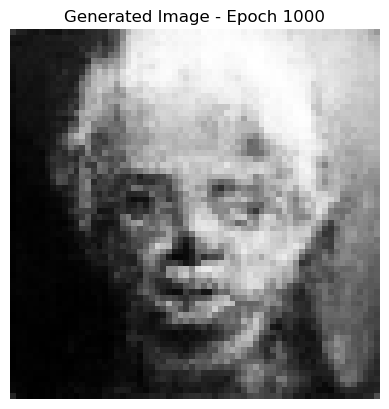

In [12]:
generate_and_show_image(gan_model.layers[0], gan_model, 1000, latent_dim)